# 🔍 Lab8 Overview: Multimodal Contrastive Representation Learning

In this lab, you'll build and analyze a compact **multimodal contrastive representation learning** system that aligns images with text embeddings. The goal is to understand how contrastive objectives can produce a shared embedding space across modalities.

You will:

- **Prepare** a filtered CIFAR-100 dataset and use a frozen **MobileNetV3 encoder** with a small trainable projection head.  
- **Train** the model using a symmetric contrastive (InfoNCE) loss to associate each image with its corresponding class word.  
- **Evaluate** the learned space through per-class similarity statistics, retrieval performance, confusion matrices, and embedding visualizations.  
- **Test generalization** by applying the model to out-of-distribution (OOD) images.  
- **Interpret** the structure and behaviour of the multimodal embedding space.

---

### 📚 Suggested Reading

For more background and inspiration, see:  
- **CLIP**: *Learning Transferable Visual Models From Natural Language Supervision* — [arXiv paper](https://arxiv.org/abs/2103.00020)
- **DETiC**: *Detecting Twenty-thousand Classes using Image-level Supervision* — [arXiv paper](https://arxiv.org/abs/2201.02605)

In [3]:
# =============================================================================
# Initialization and Environment Setup
# =============================================================================

# 📚 Import Necessary Libraries and Custom Modules
# This cell loads all required Python libraries and custom functions from the
# linked lab files. We import everything at the top for clarity.

import os
import sys
import torch
import torch.nn.functional as F

# Ensure we import from the correct directory (Q6, not AI__Code)
Q6_PATH = '/Users/voodoo/Documents/Artificial Intelligence/Q6'
if Q6_PATH not in sys.path:
    sys.path.insert(0, Q6_PATH)

# Importing text processing, analysis, and data utilities from previous labs.
# (lab2: text_network, lab6: text prep/analysis, lab7: text/image prep/analysis)
from lab2 import process_text_network
from lab6 import prepare_visual_genome_text, filter_punctuation_from_network, analyze_embeddings, find_similar_words
from lab7 import load_trained_model, create_mappings, compute_embedding_stats, get_cifar100_vocabulary, analyze_vocabulary_overlap, run_sanity_checks

# Importing all core components for the multimodal training pipeline and
# evaluation from the main script (lab8).
import importlib
import lab8
importlib.reload(lab8)  # Force reload to get the fixed version

from lab8 import (
    CIFAR100Filtered,
    ImageEncoder,
    filter_dataset_indices,
    create_data_splits,
    create_dataloaders,
    train_with_early_stopping,
    run_epoch,
    collect_embeddings,
    print_analysis_results,
    create_visualizations,
    print_example_retrievals,
    process_ood_images,
    compute_alignment_metrics,
    print_final_report
)



device = torch.device("mps")
print(f"Using device: {device} (Apple Silicon GPU)")



# The environment is now set up and all required functions are imported.

Using device: mps (Apple Silicon GPU)


In [2]:
# =============================================================================
# 🚀 STAGE 1: Load Corpus & Build Vocabulary from Visual Genome
# =============================================================================

# This initial stage prepares the text data required for the text-side embeddings.
# We use the Visual Genome (VG) dataset's region descriptions as our text corpus,
# which provides rich, descriptive language for objects and scenes.

print("\n[STAGE 1] Loading Data & Building Vocabulary")
print("-" * 70)

# 1. 📂 Define Constants and Check for Text Corpus
# We define the source URL for the VG data, the local file path, and parameters
# for filtering out very rare words and common punctuation during network creation.

TEXT_FILE = 'vg_text.txt'
ZIP_URL = "https://homes.cs.washington.edu/~ranjay/visualgenome/data/dataset/region_descriptions.json.zip"
RARE_THRESHOLD = 0.00025 # Words appearing less frequently than this threshold are marked as '<RARE>'
PUNCTUATION_TOKENS = {'.', ',', '<RARE>', "'"}

if not os.path.exists(TEXT_FILE):
    print(f"Text file not found. Downloading corpus from {ZIP_URL}...")
    # Calls a helper function to download, unzip, parse the JSON, and save the text descriptions.
    TEXT_FILE = prepare_visual_genome_text(
        zip_url=ZIP_URL,
        zip_path="region_descriptions.json.zip",
        json_path="region_descriptions.json",
        output_path=TEXT_FILE
    )
else:
    print(f"✓ Text file '{TEXT_FILE}' already exists. Skipping download and parsing.")

# 2. 🏗️ Build the Co-occurrence Network (Graph)
# The text file is processed to create a word co-occurrence network. This graph
# forms the basis for learning context-dependent word embeddings (Skip-gram, in spirit).
# The 'inverted' distance mode means closer words have a stronger connection weight.

print("\nProcessing text to build co-occurrence network...")

network_data = process_text_network(
    TEXT_FILE,
    rare_threshold=RARE_THRESHOLD,
    rare_token="<RARE>",
    distance_mode="inverted",
    verbose=True # Prints progress during network construction
)



# 3. 🗑️ Clean the Vocabulary
# Punctuation and the placeholder for rare words are filtered out from the final
# vocabulary since they are not useful for visual-semantic alignment.

#network_data = filter_punctuation_from_network(network_data, punctuation_tokens=PUNCTUATION_TOKENS)

# 4. 📊 Final Summary
# Extract the final vocabulary (nodes) and report the network statistics.
nodes = network_data['nodes']
vocab_size = 523
print(f"\n{'-'*70}")
print(f"✓ STAGE 1 Complete: Vocabulary built.")
print(f"  Total vocabulary size (nodes): {vocab_size} words")
print(f"  Total graph edges (co-occurrences): {network_data['graph'].number_of_edges():,}")


[STAGE 1] Loading Data & Building Vocabulary
----------------------------------------------------------------------
✓ Text file 'vg_text.txt' already exists. Skipping download and parsing.

Processing text to build co-occurrence network...
Loaded text: 154198751 characters
Tokenized: 33662585 tokens
Sample tokens: ['breadbaskets', 'greend', 'paso', 'mna', 'television', "'street'", 'shirtof', 'irredescent', 'onback', 'blueprints', 'buner', 'treas', 'hotel', 'sewed', "boil'", 'zpf', 'durans', 'floppy', 'juli', 'primative']
Replaced 62380 rare tokens (threshold=0.00025)
Final vocabulary: 458 unique tokens
Sample tokens: ['off', 'leaves', 'air', 'sweater', 'pavement', 'fork', 'colored', 'wing', 'blonde', 'bridge', 'feet', 'container', 'broccoli', 'shadow', 'cloud', 'tag', 'person', 'picture', 'beach', 'behind']
Graph: 458 nodes, 50128 edges
Top tokens by frequency:
   1. '.' (freq=6085975)
   2. '<RARE>' (freq=4416304)
   3. 'a' (freq=2220903)
   4. 'the' (freq=2155082)
   5. 'on' (freq=1

In [ ]:
# STAGE 2: Load Pre-trained Text Model & Compute Embedding Statistics

# This stage loads the text-side embeddings (e.g., Skip-gram or GloVe) that were
# pre-trained on the Visual Genome co-occurrence network from STAGE 1.
# These embeddings represent the semantic meaning of each word in the vocabulary.
# We also compute statistical properties of this embedding space, which are crucial
# for the subsequent genetic algorithm or training initialization.

print("\n[STAGE 2] Loading Model & Analyzing Embedding Space")
print("-" * 70)

# 1. 📂 Define Model Configuration and Load Embeddings

MODEL_PATH = 'EMB32_NG10_CS2_BS64.pth'# Path to the file containing the pre-trained embedding matrix.
EMBEDDING_DIM = 32               # Dimensionality of the word vectors.
DROPOUT = 0.3                    # Dropout rate used during the original training (if applicable).

# The `load_trained_model` function initializes the network and loads the weights.
# It returns the PyTorch model (for potential fine-tuning) and the embedding matrix itself.
model, embeddings = load_trained_model(
    model_path=MODEL_PATH,
    vocab_size=vocab_size,         # Use the size determined in STAGE 1
    embedding_dim=EMBEDDING_DIM,
    dropout=DROPOUT
)

# 2. 🗺️ Create Word-Index Mappings
# These mappings are essential for looking up the correct embedding vector
# (by index) for a given word and vice-versa.

word_to_idx, idx_to_word = create_mappings(nodes)

# 3. 📈 Compute Statistical Properties
# Analyzing the embedding space helps set hyper-parameters for optimization.
# Specifically, the global standard deviation is often used to tune the mutation
# rate in evolutionary algorithms or to initialize a new layer's weights.
embedding_stats = compute_embedding_stats(embeddings)

# 4. 📊 Final Summary
print(f"\n{'-'*70}")
print(f"✓ STAGE 2 Complete: Model loaded and stats computed.")
print(f"  Embedding matrix shape: {embeddings.shape} (Total words × Dimension)")
print(f"  Key Stats for Fitness Function:")
print(f"    ├─ Mean Vector Norm: {embedding_stats['mean_norm']:.4f} (Average magnitude of vectors)")
print(f"    ├─ Std. Dev of Norms: {embedding_stats['std_norm']:.4f}")
print(f"    └─ Global Std. Dev: {embedding_stats['global_std']:.4f} (Used for controlling search step size)")


[STAGE 2] Loading Model & Analyzing Embedding Space
----------------------------------------------------------------------
✓ Loaded model: 523 embeddings, dim=32


NameError: name 'nodes' is not defined

In [5]:
# 🔎 STAGE 3: Sanity Checks and Vocabulary Analysis

# This stage performs two essential checks:
# 1. **Sanity Checks** on the loaded text embeddings to ensure they are semantically sound
#    (e.g., that similar words have high cosine similarity).
# 2. **Vocabulary Analysis** to determine which classes from the CIFAR-100 dataset
#    have corresponding words in our pre-trained Visual Genome vocabulary.

# 1. 🧪 Perform Semantic Sanity Checks
# The `run_sanity_checks` function tests the quality of the loaded word embeddings
# by finding the nearest neighbors for a few common words. This confirms that the
# embedding space is semantically meaningful.

run_sanity_checks(model, embeddings, nodes, word_to_idx)

# 2. 📝 Vocabulary Analysis & Target Selection
# The goal is to align images (CIFAR-100) with text embeddings (Visual Genome).
# We must ensure that the class names (e.g., 'cat', 'bicycle') exist in our text vocabulary.

print("\nVocabulary Analysis & Target Selection")
print("-" * 70)

# Get the 100 class names from CIFAR-100 dataset.
cifar_vocab = get_cifar100_vocabulary()

# Check for overlap between CIFAR-100 class words and the Visual Genome vocabulary.
# This step identifies which classes we can actually train/test on.
missing_cifar_words = analyze_vocabulary_overlap(cifar_vocab, nodes)

# 3. 📊 Report Overlap Statistics
# The list of missing words shows the classes we must exclude from the training process.
# This filtered set of classes will be our final set of "seen" classes for alignment training.

n_train_classes = len(cifar_vocab) - len(missing_cifar_words)

print(f"\nSummary of Vocabulary Overlap:")
print(f"  Total CIFAR-100 Classes: {len(cifar_vocab)}")
print(f"  Classes available in VG vocabulary: {n_train_classes} (i.e., {n_train_classes/len(cifar_vocab)*100:.1f}% coverage)")
print(f"  Missing CIFAR-100 Classes: {len(missing_cifar_words)} (will be excluded from training)")

NameError: name 'nodes' is not defined

In [6]:
# TRAIN_CONFIG

TRAIN_CONFIG = {
    'proj_dim': 32,                         # Output dimension of the vision projection head
    'lr': 5e-4,                             # AdamW learning rate
    'weight_decay': 1e-3,                   # L2 regularization
    'temperature': 1.0,                     # Scaling factor for the InfoNCE logits (controls contrast sharpness)
    'epochs': 10,                          # Maximum number of epochs
    'patience': 10,                         # Early stopping patience based on validation similarity
    'batch_sizes': {'train': 512, 'eval': 256},
    'save_path': 'best_clip_vision_model.pth'
}


In [7]:
# 🧠 STAGE 4: CLIP-Style Contrastive Learning Setup and Training

# This is the core stage where the visual encoder's projection head is trained
# to align image embeddings (CIFAR-100) with their corresponding text embeddings
# (Visual Genome vocabulary). This process uses the InfoNCE loss, a form of
# contrastive learning analogous to the training used in models like CLIP.

print("\n[STAGE 4] CLIP-Style Contrastive Learning with Full Vocabulary")
print("-" * 70)

# 1. ⚙️ Define Training Configuration
# The configuration sets crucial hyper-parameters for optimization, loss function,
# and early stopping.

TRAIN_CONFIG = {
    'proj_dim': 32,                         # Output dimension of the vision projection head
    'lr': 5e-4,                             # AdamW learning rate
    'weight_decay': 1e-3,                   # L2 regularization
    'temperature': 1.0,                     # Scaling factor for the InfoNCE logits (controls contrast sharpness)
    'epochs': 5,                          # Maximum number of epochs
    'patience': 10,                         # Early stopping patience based on validation similarity
    'batch_sizes': {'train': 512, 'eval': 256},
    'save_path': 'best_clip_vision_model_test.pth'
}

# 2. 📝 Define Target Vocabulary and Embeddings

# Get the subset of CIFAR-100 class words that exist in the pre-trained VG vocabulary.
class_words = [w for w in cifar_vocab if w in word_to_idx]
print(f"\nOverlapping classes for training: {len(class_words)} / {len(cifar_vocab)}")
print(f"Training classes (first 5): {', '.join(class_words[:5])}...")

# Create label mapping for CIFAR-100 indices to their word and embedding index.
label_to_word = {i: word for i, word in enumerate(cifar_vocab)}
label_to_emb_idx = {i: word_to_idx[word] for i, word in enumerate(cifar_vocab) if word in word_to_idx}

# Extract ALL text embeddings (Full Vocabulary)
# This full set of embeddings will be used later for **zero-shot prediction** on
# the test set, allowing the model to classify images against the entire VG vocabulary.
all_vocab_words = list(word_to_idx.keys())
all_text_emb = torch.tensor(
    [embeddings[word_to_idx[word]] for word in all_vocab_words],
    dtype=torch.float32
).to(device)
all_text_emb = F.normalize(all_text_emb, p=2, dim=1) # Normalize embeddings for cosine similarity

# Extract ONLY the Training Class Embeddings (Subset)
# This subset is used *within the batch* for computing the **symmetric InfoNCE loss**
# ($\mathcal{L}_{I \to T} + \mathcal{L}_{T \to I}$).
training_text_emb = torch.tensor(
    [embeddings[word_to_idx[word]] for word in class_words],
    dtype=torch.float32
).to(device)
training_text_emb = F.normalize(training_text_emb, p=2, dim=1)

print(f"\nText embedding configuration:")
print(f"  ├─ Full vocabulary embeddings (All VG words): {all_text_emb.shape[0]} words (for OOD analysis)")
print(f"  └─ Training class embeddings: {training_text_emb.shape[0]} classes (for contrastive learning)")

# 3. 💾 Data Preparation: Create Splits and DataLoaders
print("\n[Data Split] Creating Train/Val/Test splits...")

# Load the full CIFAR-100 datasets
train_full = CIFAR100Filtered(root="./data", split="train")
test_full = CIFAR100Filtered(root="./data", split="val")

# Filter indices to include only samples belonging to the overlapping classes
all_train_idx = filter_dataset_indices(train_full, label_to_emb_idx)
test_idx = filter_dataset_indices(test_full, label_to_emb_idx)

# Split the training data into training and validation sets
train_idx, val_idx = create_data_splits(all_train_idx, val_ratio=0.2, seed=42)

print(f"Train samples: {len(train_idx):,} (for training the projection head)")
print(f"Val samples: {len(val_idx):,} (for early stopping)")
print(f"Test samples: {len(test_idx):,} (for final evaluation)")

# Create PyTorch DataLoaders for efficient batch processing
dataloaders = create_dataloaders(train_idx, val_idx, test_idx, TRAIN_CONFIG['batch_sizes'])

# 4. 🧠 Initialize and Train Model
# The ImageEncoder uses a frozen MobileNetV3 backbone and a trainable projection head.
vision_model = ImageEncoder(proj_dim=TRAIN_CONFIG['proj_dim'], device=device)

# Start training with early stopping based on validation similarity
history, best_epoch, best_val_sim, best_val_loss = train_with_early_stopping(
    vision_model, dataloaders, training_text_emb, class_words,
    label_to_word, TRAIN_CONFIG, device
)

# 5. 🎉 Final Training Summary
print("\n" + "="*70)
print("✓ Training Complete!")
print(f"Best model from epoch {best_epoch}")
print(f"Best validation similarity: {best_val_sim:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")
print("="*70)


[STAGE 4] CLIP-Style Contrastive Learning with Full Vocabulary
----------------------------------------------------------------------


NameError: name 'cifar_vocab' is not defined

In [ ]:
# Load best model for evaluation
print("\n[Loading Best Model for Final Evaluation]")
vision_model = ImageEncoder(proj_dim=TRAIN_CONFIG['proj_dim'], device=device)

if not os.path.exists(TRAIN_CONFIG['save_path']):
    raise FileNotFoundError(f"Model checkpoint not found at {TRAIN_CONFIG['save_path']}. "
                           "Training must complete at least one epoch successfully.")

# Load the saved parameters and move the model to evaluation mode
checkpoint = torch.load(TRAIN_CONFIG['save_path'])
vision_model.load_state_dict(checkpoint['model_state_dict'])
vision_model.eval()

# Extract training metadata from checkpoint for reporting
best_epoch = checkpoint['epoch']
best_val_sim = checkpoint['val_similarity']
best_val_loss = checkpoint['val_loss']
history = checkpoint.get('history', None)

print(f"✓ Loaded best model from epoch {best_epoch}")
print(f"  Val Similarity: {best_val_sim:.4f}")


[Loading Best Model for Final Evaluation]
✓ Loaded best model from epoch 5
  Val Similarity: 0.3544


In [ ]:
# =============================================================================
# FINAL TEST EVALUATION (using training classes)
# =============================================================================
print("\n" + "="*70)
print("FINAL TEST SET EVALUATION")
print("="*70)

# Run an evaluation epoch on the test dataloader. Note: 'training_text_emb'
# contains the embeddings for only the 80 overlapping classes.
test_loss, test_sim = run_epoch(
    vision_model, dataloaders['test'], training_text_emb, class_words,
    label_to_word, None, TRAIN_CONFIG['temperature'], device, 'eval'
)

print(f"\n📊 Test Results:")
print(f"  ├─ Test Loss: {test_loss:.4f} (InfoNCE)")
print(f"  └─ Test Similarity: {test_sim:.4f} (Average Cosine Similarity)")


FINAL TEST SET EVALUATION


  0%|          | 0/13 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
100%|██████████| 13/13 [00:16<00:00,  1.29s/it]


📊 Test Results:
  ├─ Test Loss: 3.1782 (InfoNCE)
  └─ Test Similarity: 0.3521 (Average Cosine Similarity)


In [ ]:
# =============================================================================
# QUANTITATIVE ANALYSIS (using training classes)
# =============================================================================
print("\n" + "="*70)
print("QUANTITATIVE ANALYSIS")
print("="*70)

# 1. Collect all visual embeddings from the test set
visual_emb, all_labels = collect_embeddings(vision_model, dataloaders['test'], device)

# 2. Compute all alignment metrics in one pass
class_stats, i2t_recalls, t2i_recalls, sim_matrix = compute_alignment_metrics(
    visual_emb, all_labels, training_text_emb.cpu().numpy(), class_words, label_to_word
)

# 3. Print structured results for easy comparison
print_analysis_results(class_stats, i2t_recalls, t2i_recalls, len(all_labels), len(class_words))


QUANTITATIVE ANALYSIS


  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


📊 Per-Class Similarity Analysis:
----------------------------------------------------------------------

Top 10 Best Aligned Classes:
 1. orange          | Mean: 0.5068 ± 0.0624
 2. chair           | Mean: 0.4755 ± 0.1447
 3. keyboard        | Mean: 0.4658 ± 0.1305
 4. apple           | Mean: 0.4601 ± 0.1287
 5. bottle          | Mean: 0.4532 ± 0.1533
 6. motorcycle      | Mean: 0.4378 ± 0.1555
 7. cloud           | Mean: 0.4362 ± 0.1564
 8. plate           | Mean: 0.4198 ± 0.1165
 9. table           | Mean: 0.4194 ± 0.1719
10. road            | Mean: 0.4182 ± 0.1221

Bottom 10 Worst Aligned Classes:
 1. man             | Mean: 0.2856 ± 0.1834
 2. baby            | Mean: 0.2782 ± 0.1726
 3. tank            | Mean: 0.2746 ± 0.1896
 4. mountain        | Mean: 0.2640 ± 0.2044
 5. bear            | Mean: 0.2531 ± 0.2079
 6. mouse           | Mean: 0.2509 ± 0.1810
 7. bowl            | Mean: 0.2400 ± 0.1820
 8. couch           | Mean: 0.2368 ± 0.2090
 9. elephant        | Mean: 0.1959 ± 0.


/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



GENERATING VISUALIZATIONS

📊 Creating confusion matrix...


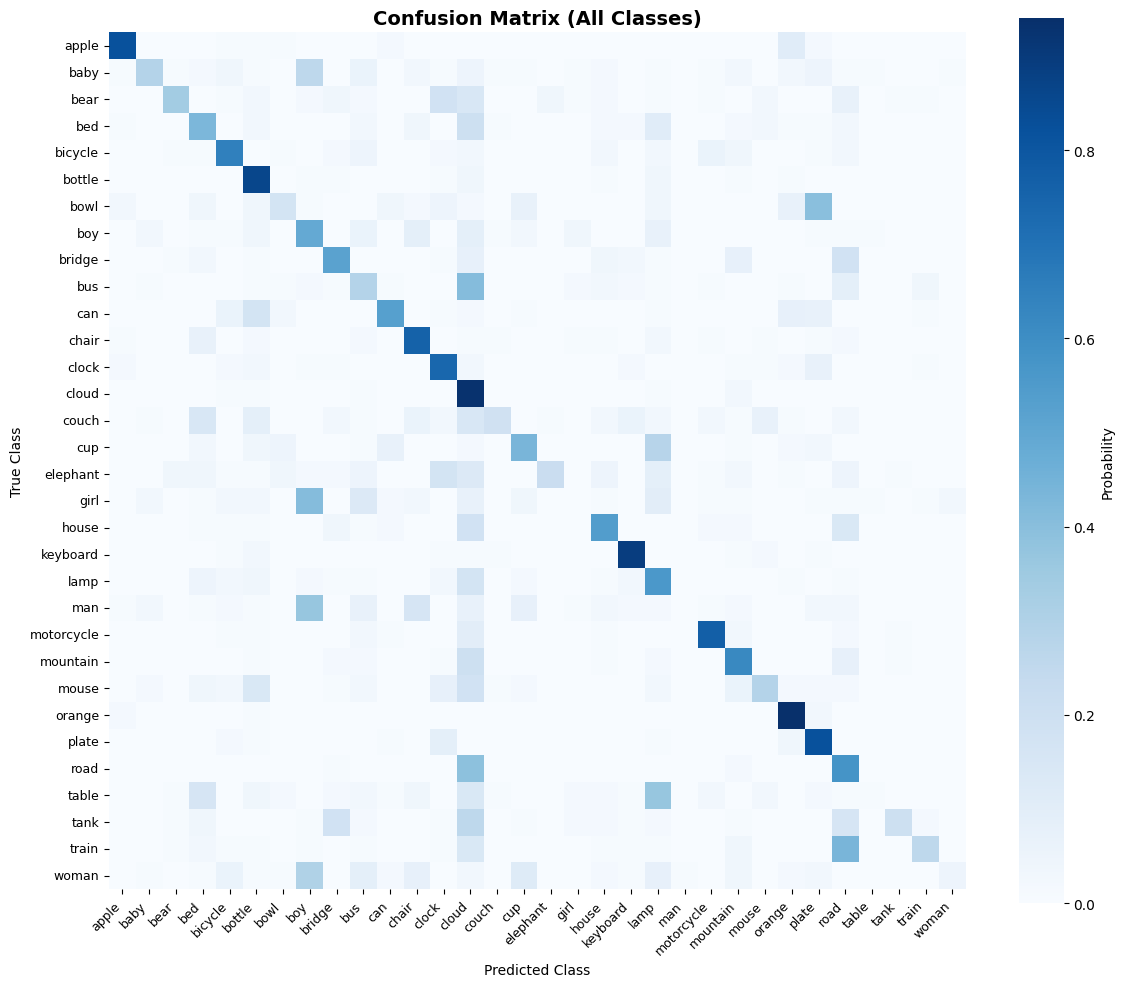


📸 Creating retrieval examples...


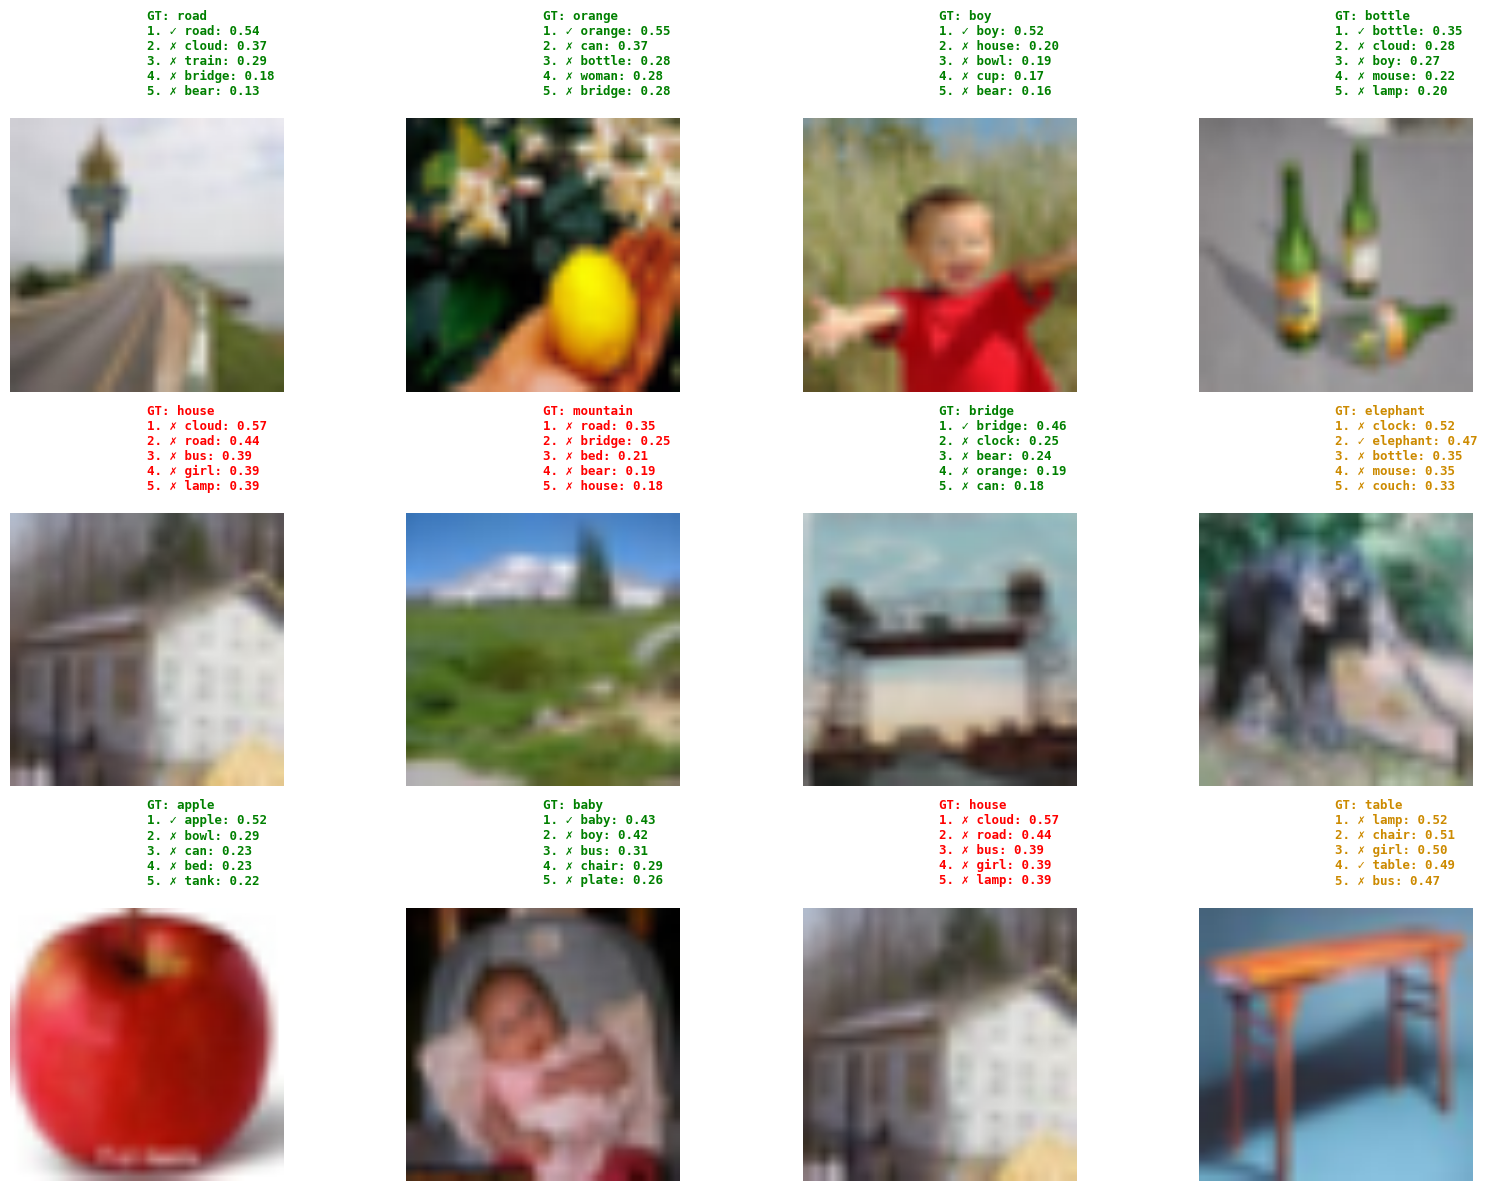


QUALITATIVE EVALUATION

📸 Example Image-to-Text Retrievals:
----------------------------------------------------------------------

Test Image #424:
  True class: 'cup' (similarity: 0.5186, rank: 2)
  Top 5 predictions:
    1.   lamp            (similarity: 0.5203)
    2. ✓ cup             (similarity: 0.5186)
    3.   girl            (similarity: 0.4987)
    4.   table           (similarity: 0.4783)
    5.   chair           (similarity: 0.4616)

Test Image #2282:
  True class: 'bear' (similarity: 0.2792, rank: 2)
  Top 5 predictions:
    1.   bridge          (similarity: 0.3226)
    2. ✓ bear            (similarity: 0.2792)
    3.   road            (similarity: 0.2480)
    4.   train           (similarity: 0.1331)
    5.   mountain        (similarity: 0.0779)

Test Image #2315:
  True class: 'baby' (similarity: 0.5546, rank: 1)
  Top 5 predictions:
    1. ✓ baby            (similarity: 0.5546)
    2.   bus             (similarity: 0.4128)
    3.   boy             (similarity: 0.3939)

In [ ]:
# =============================================================================
# VISUALIZATIONS (using training classes)
# =============================================================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Creates and saves confusion matrix and retrieval examples (plots are shown interactively)
create_visualizations(sim_matrix, all_labels, class_words, label_to_word, test_idx)

# =============================================================================
# QUALITATIVE EVALUATION (using training classes)
# =============================================================================
print("\n" + "="*70)
print("QUALITATIVE EVALUATION")
print("="*70)

# Prints text-based examples of image-to-text retrieval for a random sample of test images
print_example_retrievals(sim_matrix, all_labels, class_words, label_to_word)


OUT-OF-DISTRIBUTION IMAGE ANALYSIS

🔬 Using FULL vocabulary (458 words) for OOD predictions
   (Training only learned to separate 32 classes)

  ✓ Downloaded: jellyfish
  ✓ Downloaded: goldfish
  ✓ Downloaded: flamingo
  ✓ Downloaded: pizza
  ✓ Downloaded: strawberry
  ✓ Downloaded: hotdog
  ✓ Downloaded: banana
  ✓ Downloaded: parachute
  ✓ Downloaded: school_bus
  ✓ Downloaded: volcano
  ✓ Downloaded: submarine
  ✓ Downloaded: accordion
  ✓ Downloaded: hourglass
  ✓ Downloaded: revolver
  ✓ Downloaded: dome
  ✓ Downloaded: bobsled

🔬 Processing 16 OOD images...


/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:2


📸 Creating OOD visualization for 16 images...


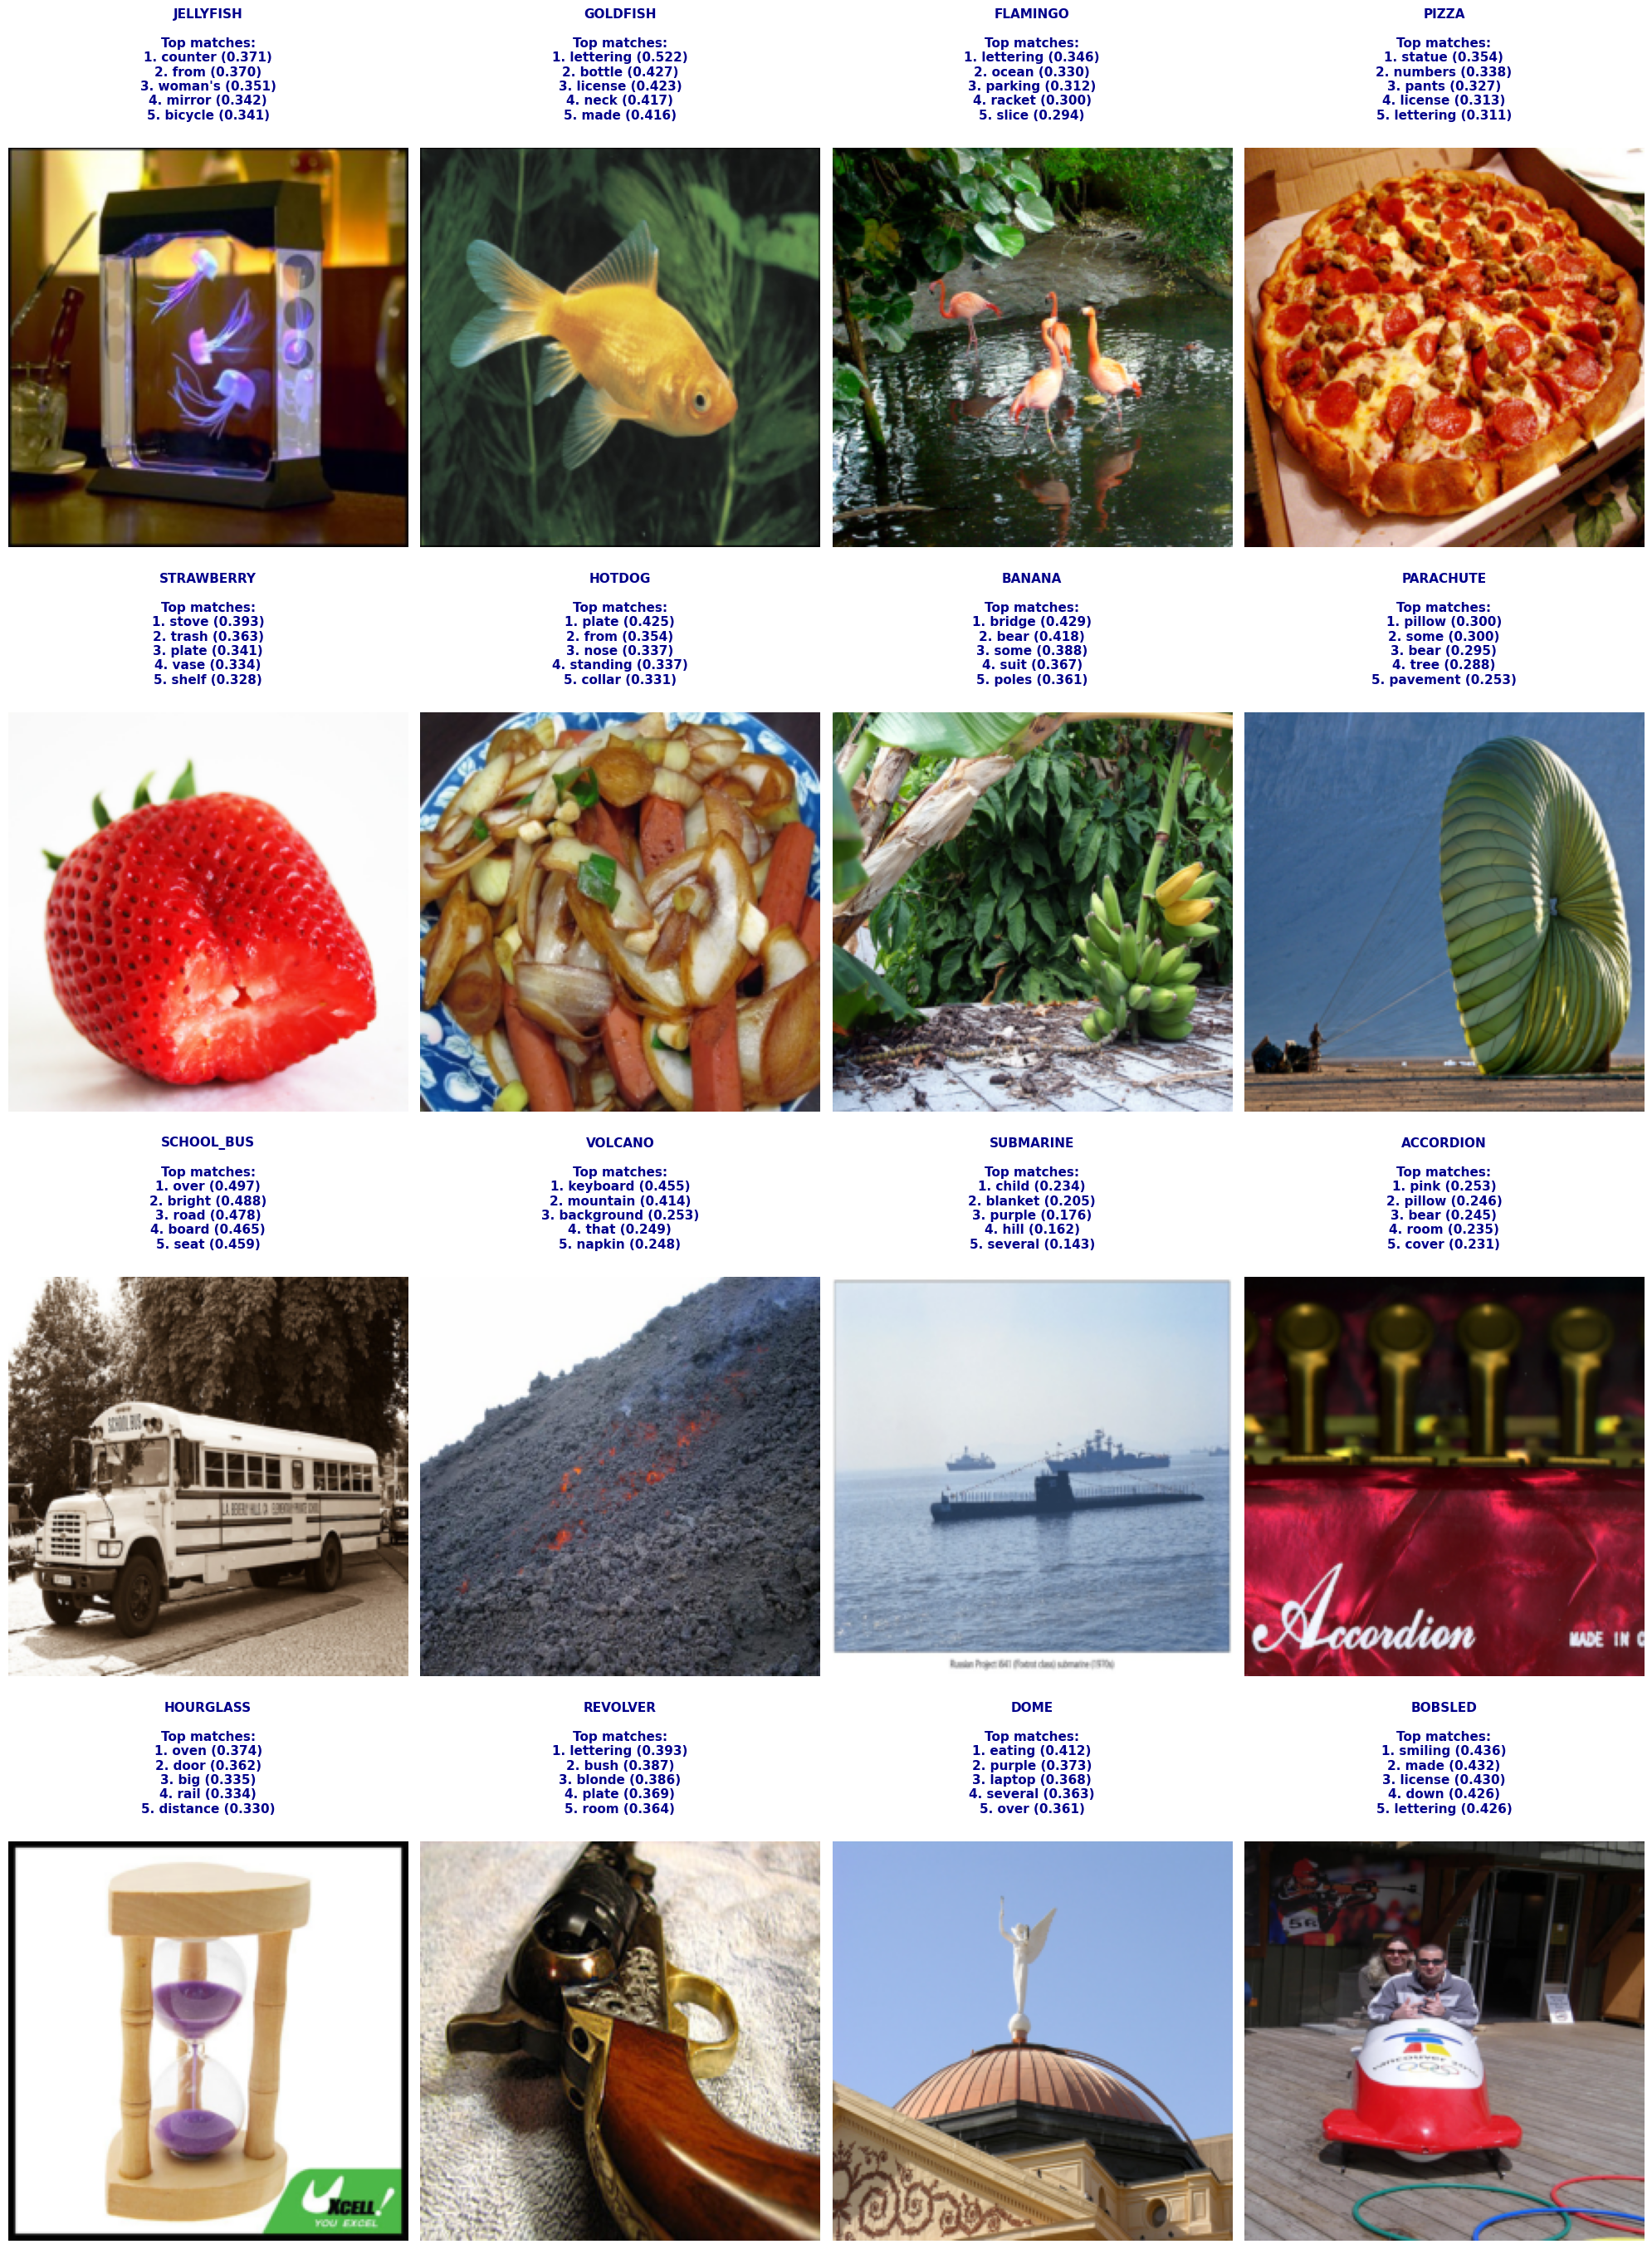

In [ ]:
# OOD test images (samples outside of the CIFAR-100 domain)
OOD_URLS = {
    "jellyfish": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01910747_jellyfish.JPEG",
    "goldfish": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01443537_goldfish.JPEG",
    "flamingo": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02007558_flamingo.JPEG",
    "pizza": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07873807_pizza.JPEG",
    "strawberry": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07745940_strawberry.JPEG",
    "hotdog": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07697537_hotdog.JPEG",
    "banana": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07753592_banana.JPEG",
    "parachute": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03888257_parachute.JPEG",
    "school_bus": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04146614_school_bus.JPEG",
    "volcano": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n09472597_volcano.JPEG",
    "submarine": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04347754_submarine.JPEG",
    "accordion": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02672831_accordion.JPEG",
    "hourglass": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03544143_hourglass.JPEG",
    "revolver": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04086273_revolver.JPEG",
    "dome": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03220513_dome.JPEG",
    "bobsled": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02860847_bobsled.JPEG",
}

# =============================================================================
# OOD IMAGE ANALYSIS (using ALL vocabulary words)
# =============================================================================
print("\n" + "="*70)
print("OUT-OF-DISTRIBUTION IMAGE ANALYSIS")
print("="*70)

print(f"\n🔬 Using FULL vocabulary ({len(all_vocab_words):,} words) for OOD predictions")
print(f"   (Training only learned to separate {len(class_words)} classes)")

# This function processes the OOD images and calculates predictions against the full vocabulary.
# all_text_emb was prepared in STAGE 4 and contains embeddings for all {vocab_size} VG words.
ood_images, ood_names, ood_predictions = process_ood_images(
    vision_model, OOD_URLS, all_text_emb.cpu().numpy(), all_vocab_words, device
)

# If any images were successfully downloaded and processed, generate a visualization.
if len(ood_images) > 0:
    # The visualization function is reused, but now receives the OOD data
    # (images, names, predictions) to create a dedicated analysis plot.
    create_visualizations(sim_matrix, all_labels, class_words, label_to_word, test_idx,
                         ood_images, ood_names, ood_predictions)

In [ ]:
# =============================================================================
# FINAL REPORT
# =============================================================================
# The final report function gathers all collected metrics and parameters
# (from TRAIN_CONFIG, test results, retrieval metrics, and OOD analysis)
# to print a comprehensive, structured summary.

print_final_report(
    TRAIN_CONFIG, test_loss, test_sim, i2t_recalls, t2i_recalls, class_stats,
    len(train_idx), len(val_idx), len(test_idx), len(class_words),
    TRAIN_CONFIG['batch_sizes']['train'], len(ood_images) > 0,
    history, best_epoch, best_val_sim, best_val_loss, len(all_vocab_words)
    )


📋 Training Configuration:
   ├─ Model: MobileNetV3-Small with projection head
   ├─ Embedding dimension: 32
   ├─ Training samples: 12,800, Validation samples: 3,200, Test samples: 3,200
   ├─ Number of training classes: 32
   ├─ Total vocabulary size: 455 words
   ├─ Total epochs trained: 7, Best epoch: 7
   └─ Early stopping patience: 10

🎯 Performance Metrics:
   ├─ Best Val Similarity: 0.3608
   ├─ Test Similarity: 0.3625, Test Loss: 3.1512
   ├─ Random baseline loss: ~6.24
   │
   ├─ Image→Text Recall@1: 56.06%
   ├─ Image→Text Recall@5: 81.19%
   ├─ Image→Text Recall@10: 90.47%
   │
   ├─ Text→Image Recall@1: 87.50%
   ├─ Text→Image Recall@5: 96.88%
   └─ Text→Image Recall@10: 100.00%

📊 Embedding Space Alignment:
   ├─ Mean per-class similarity: 0.3625 ± 0.0795
   ├─ Best aligned class: 'apple' (0.5045)
   └─ Worst aligned class: 'woman' (0.2139)

💡 Key Insights:
   • The model attempts to learn visual-text alignment
   • Low overall alignment (similarity: 0.3625)
   • Loss: 3.

In [ ]:
from lab8 import run_tests

run_tests()

ImportError: cannot import name 'run_tests' from 'lab8' (/Users/voodoo/Documents/Artificial Intelligence/Q6/lab8.py)

In [13]:
import torch

checkpoint = torch.load('best_clip_vision_model.pth', map_location='cpu')
print(checkpoint.keys())  # See what's saved

# If it has 'model_state_dict':
state_dict = checkpoint['model_state_dict']
for name, param in state_dict.items():
    print(f"{name}: {param.shape}")


dict_keys(['epoch', 'model_state_dict', 'val_loss', 'val_similarity', 'class_words', 'text_embeddings', 'history', 'projection_head'])
backbone.0.0.0.weight: torch.Size([16, 3, 3, 3])
backbone.0.0.1.weight: torch.Size([16])
backbone.0.0.1.bias: torch.Size([16])
backbone.0.0.1.running_mean: torch.Size([16])
backbone.0.0.1.running_var: torch.Size([16])
backbone.0.0.1.num_batches_tracked: torch.Size([])
backbone.0.1.block.0.0.weight: torch.Size([16, 1, 3, 3])
backbone.0.1.block.0.1.weight: torch.Size([16])
backbone.0.1.block.0.1.bias: torch.Size([16])
backbone.0.1.block.0.1.running_mean: torch.Size([16])
backbone.0.1.block.0.1.running_var: torch.Size([16])
backbone.0.1.block.0.1.num_batches_tracked: torch.Size([])
backbone.0.1.block.1.fc1.weight: torch.Size([8, 16, 1, 1])
backbone.0.1.block.1.fc1.bias: torch.Size([8])
backbone.0.1.block.1.fc2.weight: torch.Size([16, 8, 1, 1])
backbone.0.1.block.1.fc2.bias: torch.Size([16])
backbone.0.1.block.2.0.weight: torch.Size([16, 16, 1, 1])
backbone

In [ ]:
# NOTE RETRAIN CLIP MODEL ONE LAST TIME W
# WITH OPTIMAL PARAMETERS